In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
from pgso.test_functions import *
from pgso.gso import GSO as PGSO, PSO_purana
from pgso.benchmark import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
import scipy.io
from numba import jit

# PSO IMPLEMENTATION

In [3]:
#dependencies
import random
import math
import copy # for array copying
import sys

class Particle:
    def __init__(self,x0, num_dimensions):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual
        self.num_dimensions = num_dimensions
        
        for i in range(0, self.num_dimensions):
            self.velocity_i.append(random.uniform(-1,1))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i)

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # update new particle velocity
    def update_velocity(self,pos_best_g):
        w=0.5       # constant inertia weight (how much to weigh the previous velocity)
        c1=1        # cognative constant
        c2=2        # social constant

        for i in range(0, self.num_dimensions):
            r1=random.random()
            r2=random.random()

            vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self,bounds):
        for i in range(0, self.num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

            # adjust maximum position if necessary
            if self.position_i[i]>bounds[i][1]:
                self.position_i[i]=bounds[i][1]

            # adjust minimum position if neseccary
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i]=bounds[i][0]

def PSO(costFunc,bounds,maxiter, swarm_init, log=False, the_list=None):
    num_dimensions=len(swarm_init[0])
    err_best_g=-1                   # best error for group
    pos_best_g=[]                   # best position for group
    num_particles = len(swarm_init)
    # establish the swarm
    swarm = [Particle(position, num_dimensions) for position in swarm_init]
    # begin optimization loop
    i=0
    while i < maxiter:
        #print i,err_best_g
        # cycle through particles in swarm and evaluate fitness
        for j in range(0,num_particles):
            swarm[j].evaluate(costFunc)

            # determine if current particle is the best (globally)
            if swarm[j].err_i < err_best_g or err_best_g == -1:
                pos_best_g=list(swarm[j].position_i)
                err_best_g=float(swarm[j].err_i)

        # cycle through swarm and update velocities and position
        for j in range(0,num_particles):
            swarm[j].update_velocity(pos_best_g)
            swarm[j].update_position(bounds)
        if log:
            the_list.append(err_best_g)
        i+=1
    return pos_best_g, err_best_g

# GSO IMPLEMENTATION

In [4]:
def GSO(M, bounds, num_particles, max_iter, costfunc, log=False, the_list=None):
    subswarm_bests = []
    dims = len(bounds)
    lb = bounds[0][0] 
    ub = bounds[0][1] 
    for i in range(M):
        swarm_init = [np.random.uniform(lb, ub, dims) for _ in range(num_particles)]
        temp_list = list()
        subswarm_best,_ = PSO(costfunc,bounds,max_iter, swarm_init=swarm_init, log=True, the_list=temp_list)
        subswarm_bests.append(subswarm_best)
        if log:
            the_list.append(temp_list)
    best_position, best_error = PSO(costfunc, bounds, max_iter, swarm_init=subswarm_bests)
    return best_position, best_error

# ROTATED and SHIFTED FUNCTIONS

In [5]:
def rotated_rastrigin(x):
    if len(x) == 10:
        mat = scipy.io.loadmat('./matlab-files/rastrigin_M_D10.mat')
    elif len(x) == 30:
        mat = scipy.io.loadmat('./matlab-files/rastrigin_M_D30.mat')
    elif len(x) == 50:
        mat = scipy.io.loadmat('./matlab-files/rastrigin_M_D50.mat')
    y = np.matmul(mat['M'],x)
    return rastrigin(y)

def rotated_griewangk(x):
    if len(x) == 10:
        mat = scipy.io.loadmat('./matlab-files/griewank_M_D10.mat')
    elif len(x) == 30:
        mat = scipy.io.loadmat('./matlab-files/griewank_M_D30.mat')
    elif len(x) == 50:
        mat = scipy.io.loadmat('./matlab-files/griewank_M_D50.mat')
    y = np.matmul(mat['M'],x)
    return griewank(y)

def rotated_ackley(x):
    if len(x) == 10:
        mat = scipy.io.loadmat('./matlab-files/ackley_M_D10.mat')
    elif len(x) == 30:
        mat = scipy.io.loadmat('./matlab-files/ackley_M_D30.mat')
    elif len(x) == 50:
        mat = scipy.io.loadmat('./matlab-files/ackley_M_D50.mat')
    y = np.matmul(mat['M'],x)
    return ackley(x)

def shifted_rotated_rastrigin(x):
    o = np.random.uniform(-2, 2, len(x))
    x = x - o
    return rotated_rastrigin(x)

def shifted_rotated_ackley(x):
    o = np.random.uniform(-2, 2, len(x))
    x = x - o
    return rotated_ackley(x)

In [6]:
unimodal_functions = [exponential, powellsumfcn, sum_of_squares, schfewel_220, schwefel_222, griewank, zakharov, sphere]
unimodal_strings = ['exponential', ' powell sum function', ' sum_of_squares', ' schfewel 2.20', ' schwefel 2.22', ' griewank', ' zakharov', ' sphere']
unimodal_bounds = [[-1, 1], [-1, 1], [-10, 10], [-100, 100], [-100, 100], [-600, 600], [-5, 10], [-100, 100]]

multimodal_functions = [nonContinuousRastrigin, ackley, rastrigin, rosen, rotated_rastrigin, rotated_griewangk, rotated_ackley, shifted_rotated_rastrigin, shifted_rotated_ackley]
multimodal_strings = ['nonContinuousRastrigin', 'ackley', 'rastrigin', 'rosen', "rotated_rastrigin", "rotated_griewangk", "rotated_ackley", "shifted_rotated_rastrigin", "shifted_rotated_ackley"]
multimodal_bounds = [[-100, 100], [-40, 40], [-100, 100], [-30, 30], [-100, 100], [-600, 600], [-40, 40], [-5.12, 5.12], [-10, 10]]

In [7]:
def get_GSO_results(dimensions, bounds, costfunc, algorithm, M, num_particles, max_iter, suppress=True):
    search_space = [bounds for _ in range(dimensions)]
    if not suppress:
        print("\n Algorithm: ", algorithm,"\n Dimensions: ", dimensions,"\n cost function: ", costfunc,"\n iterations: ", max_iter)
    score = 0
    for _ in range(10):
        score += algorithm(M, search_space, num_particles, max_iter, costfunc)[1]
    score = score / 10
    return score

def run_test(dimensions, algorithm, M, num_particles, max_iter, mode="unimodal"):
    modal_tests = dict()
    if mode == "unimodal":
        for func, bnds, stri in zip(unimodal_functions, unimodal_bounds, unimodal_strings):
            modal_tests[stri] = get_GSO_results(dimensions, bnds, func, algorithm, M, num_particles, max_iter)
    else:
        for func, bnds, stri in zip(multimodal_functions, multimodal_bounds, multimodal_strings):
            modal_tests[stri] = get_GSO_results(dimensions, bnds, func, algorithm, M, num_particles, max_iter)
    return modal_tests

# Unimodal on GSO

In [8]:
print(run_test(10, GSO, 7, 20, 1000))
print(run_test(30, GSO, 7, 20, 1000))
print(run_test(50, GSO, 7, 20, 1000))

KeyboardInterrupt: 

# Multimodal On GSO

In [38]:
print(run_test(10, GSO, 7, 20, 1000, "multimodal"))
print(run_test(30, GSO, 7, 20, 1000, "multimodal"))
print(run_test(50, GSO, 7, 20, 1000, "multimodal"))

{'nonContinuousRastrigin': 28.405503697535302, 'ackley': 1.6874087146866756, 'rastrigin': 32.63602528462998, 'rosen': 5.200615042737145, 'rotated_rastrigin': 46.813335445181316, 'rotated_griewangk': 0.32503702657477496, 'rotated_ackley': 1.9517829210475557, 'shifted_rotated_rastrigin': 87.05403437132182, 'shifted_rotated_ackley': 4.404317307954242}
{'nonContinuousRastrigin': 1661.5908171298029, 'ackley': 19.52829931415535, 'rastrigin': 1099.4411045178742, 'rosen': 32716.237738523225, 'rotated_rastrigin': 11291.556480095092, 'rotated_griewangk': 162.49799283670683, 'rotated_ackley': 19.3806081600923, 'shifted_rotated_rastrigin': 473.65034908929954, 'shifted_rotated_ackley': 10.826823909590434}
{'nonContinuousRastrigin': 18378.96001992069, 'ackley': 19.975863094473095, 'rastrigin': 18410.53006056455, 'rosen': 2315366.1817619773, 'rotated_rastrigin': 45400.88049215202, 'rotated_griewangk': 883.5469045765418, 'rotated_ackley': 19.93253433234317, 'shifted_rotated_rastrigin': 982.56569464534

# Unimodal on PGSO

In [36]:
print(run_test(10, PGSO, 7, 20, 1000))
print(run_test(30, PGSO, 7, 20, 1000))
print(run_test(50, PGSO, 7, 20, 1000))

{'exponential': 0.0, ' powell sum function': 0.0, ' sum_of_squares': 0.0, ' schfewel 2.20': 0.0, ' schwefel 2.22': 0.0, ' griewank': 0.0, ' zakharov': 0.0, ' sphere': 0.0}
{'exponential': 0.0, ' powell sum function': 0.0, ' sum_of_squares': 0.0, ' schfewel 2.20': 0.0, ' schwefel 2.22': 0.0, ' griewank': 0.09949590570932898, ' zakharov': 0.0, ' sphere': 0.0}
{'exponential': 0.0, ' powell sum function': 0.0, ' sum_of_squares': 0.0, ' schfewel 2.20': 0.0, ' schwefel 2.22': 0.0, ' griewank': 0.09949590570932898, ' zakharov': 0.0, ' sphere': 0.0}


# Multimodal on PGSO

In [39]:
print(run_test(10, PGSO, 7, 20, 1000, "multimodal"))
print(run_test(30, PGSO, 7, 20, 1000, "multimodal"))
print(run_test(50, PGSO, 7, 20, 1000, "multimodal"))

{'nonContinuousRastrigin': 0.0, 'ackley': 0.0, 'rastrigin': 0.0, 'rosen': 0.19899181141865796, 'rotated_rastrigin': 0.19899181141865796, 'rotated_griewangk': 0.09949590570932898, 'rotated_ackley': 0.0, 'shifted_rotated_rastrigin': 0.09949590570932898, 'shifted_rotated_ackley': 0.19899181141865796}
{'nonContinuousRastrigin': 0.0, 'ackley': 0.0, 'rastrigin': 0.0, 'rosen': 0.09949590570932898, 'rotated_rastrigin': 0.0, 'rotated_griewangk': 0.0, 'rotated_ackley': 0.09949590570932898, 'shifted_rotated_rastrigin': 0.19899181141865796, 'shifted_rotated_ackley': 0.0}
{'nonContinuousRastrigin': 0.0, 'ackley': 0.0, 'rastrigin': 0.0, 'rosen': 0.09949590570932898, 'rotated_rastrigin': 0.0, 'rotated_griewangk': 0.0, 'rotated_ackley': 0.0, 'shifted_rotated_rastrigin': 0.19899181141865796, 'shifted_rotated_ackley': 0.0}


# PSO

In [8]:
def True_PSO(costFunc,bounds,maxiter, num_particles, log=False, the_list=None):
    lb = bounds[0][0]
    ub = bounds[0][1]
    
    num_dimensions=len(bounds)
    swarm_init = np.array([np.random.uniform(lb, ub, num_dimensions) for _ in range(num_particles)])
    
    err_best_g=-1                   # best error for group
    pos_best_g=[]                   # best position for group
    # establish the swarm
    swarm = [Particle(position, num_dimensions) for position in swarm_init]
    # begin optimization loop
    i=0
    while i < maxiter:
        #print i,err_best_g
        # cycle through particles in swarm and evaluate fitness
        for j in range(0,num_particles):
            swarm[j].evaluate(costFunc)

            # determine if current particle is the best (globally)
            if swarm[j].err_i < err_best_g or err_best_g == -1:
                pos_best_g=list(swarm[j].position_i)
                err_best_g=float(swarm[j].err_i)

        # cycle through swarm and update velocities and position
        for j in range(0,num_particles):
            swarm[j].update_velocity(pos_best_g)
            swarm[j].update_position(bounds)
        if log:
            the_list.append(err_best_g)
        i+=1
    return pos_best_g, err_best_g

In [9]:
def run_PSO_tests(dimensions, maxiter, num_particles, mode="unimodal"):
    results_dict = dict()
    if mode == "unimodal":
        functions = unimodal_functions
        strings = unimodal_strings
        bounds = unimodal_bounds
    else:
        functions = multimodal_functions
        strings = multimodal_strings
        bounds = multimodal_bounds

    for func, bnds, stri in zip(functions, bounds, strings):
        search_space = [bnds for _ in range(dimensions)]            
        score = 0
        for _ in range(10):
            score += True_PSO(func, search_space, maxiter, num_particles)[1]
        score = score/10
        results_dict[stri] = score
    return results_dict    

# Unimodal on PSO

In [21]:
print(run_PSO_tests(10, 1000, 50))
print(run_PSO_tests(30, 1000, 50))
print(run_PSO_tests(50, 1000, 50))

{'exponential': -0.9606530659712632, ' powell sum function': 1.294820677780308e-14, ' sum_of_squares': 40.00000000000001, ' schfewel 2.20': 10.028387353541428, ' schwefel 2.22': 218.96078690592313, ' griewank': 0.2135347715875347, ' zakharov': 54.407368891183594, ' sphere': 1.8000001596299296e-85}
{'exponential': -0.569954966783031, ' powell sum function': 0.20000094266331553, ' sum_of_squares': 1978.1932797921913, ' schfewel 2.20': 322.7206393196454, ' schwefel 2.22': 1122.0745010542857, ' griewank': 129.3991502466623, ' zakharov': 569.5838732189188, ' sphere': 10191.371524269203}
{'exponential': -0.2046134408101108, ' powell sum function': 0.10003236426881243, ' sum_of_squares': 9268.900390238367, ' schfewel 2.20': 874.4493281543882, ' schwefel 2.22': 1996.607858206618, ' griewank': 353.09732788997127, ' zakharov': 1389.0649821095462, ' sphere': 27710.16735336067}


# Multimodal on PSO

In [11]:
print(run_PSO_tests(10, 1000, 50, 'multimodal'))
print(run_PSO_tests(30, 1000, 50, 'multimodal'))
print(run_PSO_tests(50, 1000, 50, 'multimodal'))

{'nonContinuousRastrigin': 45.369696174550235, 'ackley': 4.688500870933288, 'rastrigin': 37.012100026086046, 'rosen': 27020.582037994183, 'rotated_rastrigin': 57.01070702031851, 'rotated_griewangk': 14.315162917924164, 'rotated_ackley': 2.9223501685301487, 'shifted_rotated_rastrigin': 76.5450011583918, 'shifted_rotated_ackley': 3.9927671512405554}
{'nonContinuousRastrigin': 12847.078367198133, 'ackley': 19.63309226185815, 'rastrigin': 17177.214038425613, 'rosen': 16035719.965090323, 'rotated_rastrigin': 32271.41577352505, 'rotated_griewangk': 505.2310348760282, 'rotated_ackley': 19.771743236762084, 'shifted_rotated_rastrigin': 537.0415308182588, 'shifted_rotated_ackley': 11.650072077546685}
{'nonContinuousRastrigin': 39134.41851763637, 'ackley': 19.944744475463775, 'rastrigin': 35905.26947147814, 'rosen': 74040494.65318504, 'rotated_rastrigin': 82148.19678362487, 'rotated_griewangk': 1615.5849954438013, 'rotated_ackley': 19.977639167976378, 'shifted_rotated_rastrigin': 1057.52770420197

In [10]:
graph_functions = [nonContinuousRastrigin, rotated_ackley, rotated_rastrigin, rotated_griewangk, griewank, rosen, sphere]
graph_bounds = [[-100, 100], [-40, 40], [-100, 100], [-600, 600], [-600, 600], [-30, 30], [-100, 100]]

def make_graphs(iterations, func, bounds, dims, algo="pso"):
    search_space = [bounds for _ in range(dims)]
    if algo == "pso":
        errors = list()
        for i in tqdm(range(iterations)):
            errors.append(True_PSO(func, search_space, i, 20)[1])
    else:
        errors = list()
        if algo == 'gso':
            algo = GSO
        else:
            algo = PGSO
        for i in tqdm(range(10, iterations)):
            errors.append(algo(5, search_space, 20, i, func))
    return errors

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.lines as mlines
%matplotlib inline

In [45]:
pso_list = list()
search_space = [graph_bounds[0] for _ in range(50)]
_ = True_PSO(graph_functions[0], search_space, 1500, 20, log=True, the_list=pso_list)

In [40]:
len(pso_list)

1500

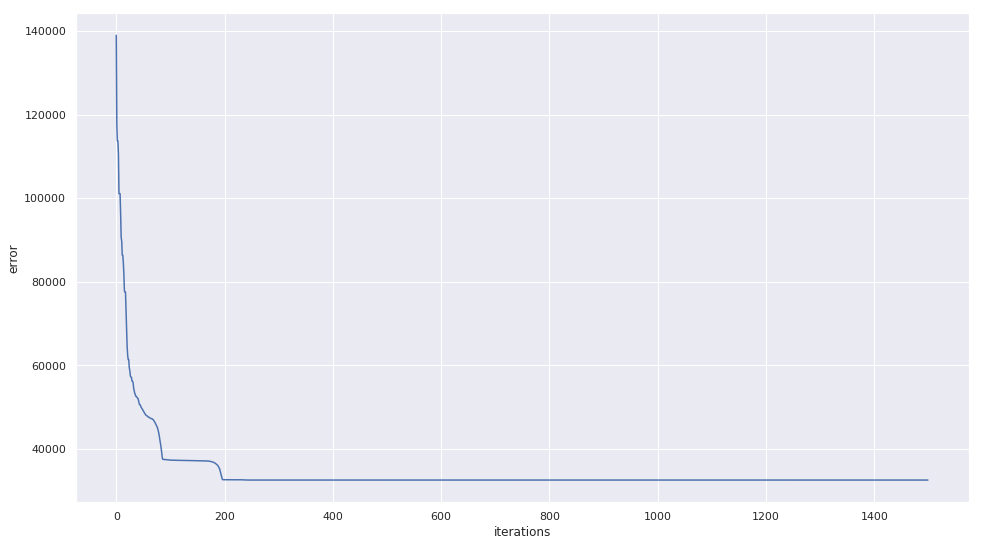

In [50]:
iterations = [i for i in range(1500)]
df = pd.DataFrame({'iterations': iterations, 'error': pso_list})

plt.figure(figsize=(16,9))
sns.set()
_ = sns.lineplot(x="iterations",y="error", data=df)

In [46]:
# nonContinuousRastrigin
# GSO
gso_list = list()
_ = GSO(5, search_space, 20, 1500, graph_functions[0], log=True, the_list=gso_list)

In [47]:
gso_true_list = list()
for i,j,k,l,m in zip(gso_list[0], gso_list[1], gso_list[2], gso_list[3], gso_list[4]):
    gso_true_list.append((i + j + k + l + m)/5)

In [44]:
len(gso_true_list)

1500

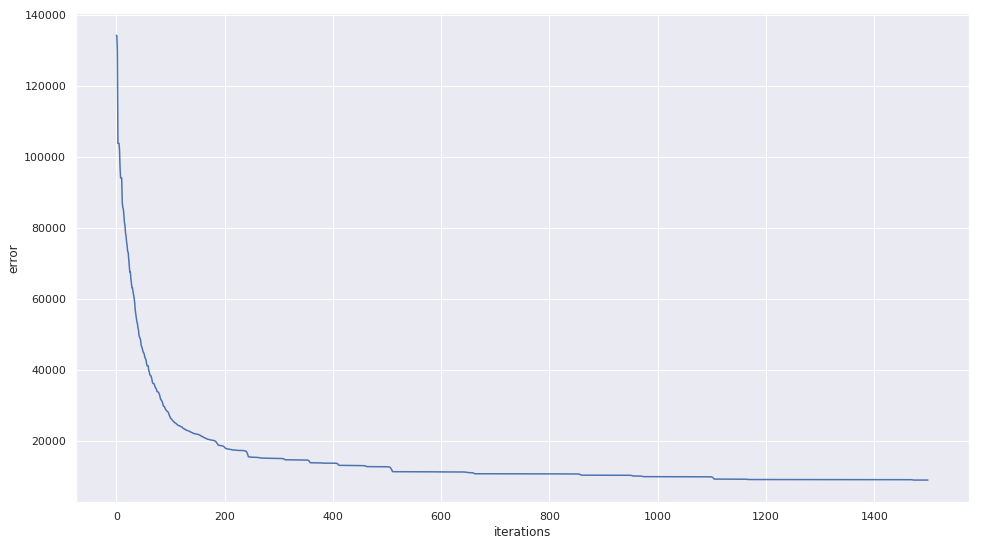

In [51]:
iterations = [i for i in range(1500)]
df2 = pd.DataFrame({'iterations': iterations, 'error': gso_true_list})

plt.figure(figsize=(16,9))
sns.set()
_ = sns.lineplot(x="iterations",y="error", data=df2)

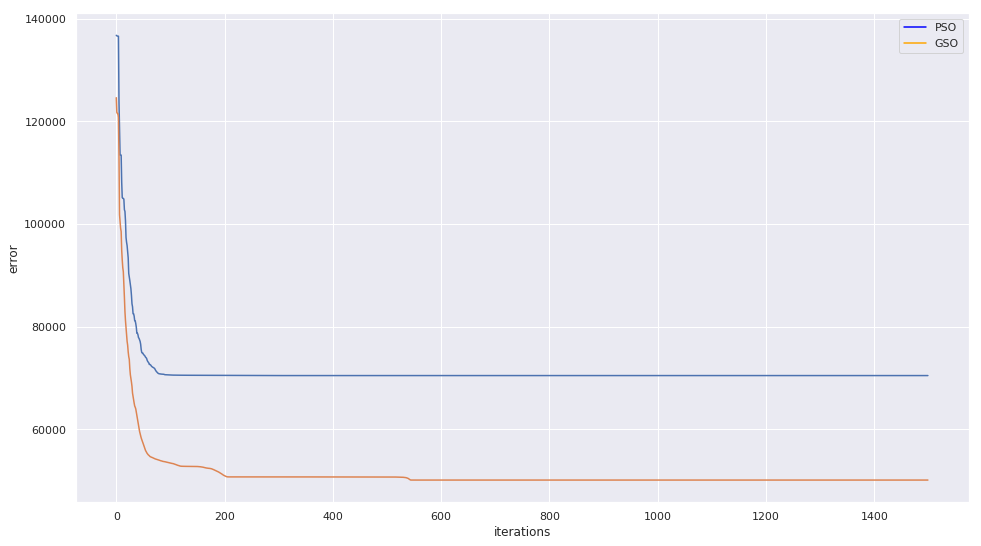

In [68]:
sns.set()
plt.figure(figsize=(16,9))
ax = plt.gca()
blue_line = mlines.Line2D([],[],color='blue', label='PSO', markersize='20')
orange_line = mlines.Line2D([],[],color='orange', label='GSO', markersize='20')

a = sns.lineplot(x='iterations', y='error', data=df, ax=ax)
b = sns.lineplot(x='iterations', y='error', data=df2, ax=ax)
# a.legend()
_ = ax.legend(handles=[blue_line, orange_line])

In [54]:
# %%writefile ../pgso/gso.py
from pgso.evaluate import error, evaluate, update_velocity, update_position
from multiprocessing import Manager, Process, Lock
from pgso.init_particles import create_n_particles
from numba import jit
import numpy as np


# @jit
def PSO_purana(costFunc,bounds,maxiter,swarm_init=None, log=False, the_list=None):
        
    num_dimensions=len(swarm_init[0])
    err_best_g=-1                   # best error for group
    pos_best_g=[]                   # best position for group
    num_particles = len(swarm_init)
    # establish the swarm
    swarm = create_n_particles(num_particles, num_dimensions, swarm_init)
    if log:
        err_log_list = []
    # begin optimization loop
    i=0
    while i < maxiter:
        #print i,err_best_g
        # cycle through particles in swarm and evaluate fitness
        for j in range(0,num_particles):
            swarm[j]['pos_best_i'], swarm[j]['err_best_i']  = evaluate(costFunc, swarm[j])

            # determine if current particle is the best (globally)
            if swarm[j]['err_i'] < err_best_g or err_best_g == -1:
                pos_best_g=list(swarm[j]['position_i'])
                err_best_g=float(swarm[j]['err_i'])

        # cycle through swarm and update velocities and position
        for j in range(0,num_particles):
            swarm[j]['velocity_i'] = update_velocity(pos_best_g, swarm[j])
            swarm[j]['position_i'] = update_position(bounds, swarm[j])
        i+=1
        if log:
            err_log_list.append(err_best_g)
    if log:
        the_list.append(err_log_list)
    # print final results
    #print ('\n')
    #print (pos_best_g,' , ', err_best_g)
    return pos_best_g[0], err_best_g

# @jit
def PSO(costFunc,bounds,maxiter,shared_list, return_list, l,num_particles=None,swarm_init=None, log=True, t_list=None):

            
    num_dimensions=len(swarm_init[0])
    err_best_g=-1                   # best error for group
    pos_best_g=[]                   # best position for group
    num_particles = len(swarm_init)
    # establish the swarm
    swarm = create_n_particles(num_particles, num_dimensions, swarm_init)
    # begin optimization loop
    i=0
    while i < maxiter:
        #print i,err_best_g
        # cycle through particles in swarm and evaluate fitness
        for j in range(0,num_particles):
            best_pos, swarm[j]['err_best_i']  = evaluate(costFunc, swarm[j])
            swarm[j]['pos_best_i'] = best_pos
            # determine if current particle is the best (globally)
            if swarm[j]['err_i'] < err_best_g or err_best_g == -1:
                pos_best_g=list(swarm[j]['position_i'])
                err_best_g=float(swarm[j]['err_i'])
        
        # update the global best in the manager list after k iterations
        # we need to add some mutex lock here
        
        if i == maxiter//2:
            l.acquire()
            best_galactic_pos = shared_list[0]
            best_galactic_err = shared_list[1]
            #print("best_galactic_err: " ,best_galactic_err)
            #print("best_galactic_pos: ", best_galactic_pos)
            if err_best_g < best_galactic_err and err_best_g != -1:
                shared_list[1] = err_best_g
                #print(err_best_g)
                shared_list[0] = pos_best_g
            else:
                #print("changing pos_best_g from", pos_best_g, " to ", best_galactic_pos)
                #emp_list = []
                err_best_g = float(best_galactic_err)
                #emp_list.append(best_galactic_pos)
                pos_best_g = [best_galactic_pos]
            
            l.release()
        # cycle through swarm and update velocities and position
        for j in range(0,num_particles):
            swarm[j]['velocity_i'] = update_velocity(pos_best_g, swarm[j])
            swarm[j]['position_i'] = update_position(bounds, swarm[j])
        if log:
            t_list.append(err_best_g)
        i+=1
    return_list.append(pos_best_g[0])


def start(process_list):
    for p in process_list:
        p.start()
        
def stop(process_list):
    for p in process_list:
        p.join()

# @jit
def GSO(M, bounds, num_particles, max_iter, costFunc, log=False, the_list=None):
    """
    Galactic Swarm Optimization:
    ----------------------------
    A meta-heuristic algorithm insipred by the interplay
    of stars, galaxies and superclusters under the influence
    of gravity.
    
    Input:
    ------
    M: integer 
    number of galaxies
    bounds: 
    bounds of the search space
    
    """
    subswarm_bests = []
    dims = len(bounds)
    lb = bounds[0][0] 
    ub = bounds[0][1]
    manager = Manager()
    l = Lock()
    shared_list = manager.list()
    return_list = manager.list()
    shared_list = [np.random.uniform(lb, ub, dims), 10000000] # like np.inf
    all_processes = []
    list1 = manager.list()
    list2 = manager.list()
    list3 = manager.list()
    list4 = manager.list()
    list5 = manager.list()
    for i in range(M):
        #initial= np.random.uniform(-10,10, 2)               # initial starting location [x1,x2...]         
        swarm_init = []
        for _ in range(num_particles):
            swarm_init.append(np.random.uniform(lb, ub, dims))
        
        if log:
            if i == 0:
                p = Process(target=PSO, args=(costFunc, bounds, max_iter, shared_list, return_list, l, None, swarm_init, True, list1))
            elif i == 1:
                p = Process(target=PSO, args=(costFunc, bounds, max_iter, shared_list, return_list, l, None, swarm_init, True, list2))
            elif i == 2:
                p = Process(target=PSO, args=(costFunc, bounds, max_iter, shared_list, return_list, l, None, swarm_init, True, list3))
            elif i == 3:
                p = Process(target=PSO, args=(costFunc, bounds, max_iter, shared_list, return_list, l, None, swarm_init, True, list4))
            elif i == 4:
                p = Process(target=PSO, args=(costFunc, bounds, max_iter, shared_list, return_list, l, None, swarm_init, True, list5))
        else:
            p = Process(target=PSO, args=(costFunc, bounds, max_iter, shared_list, return_list, l, None,swarm_init))
        all_processes.append(p)

    start(all_processes)
    stop(all_processes)
    if log:
        the_list.append(list1)
        the_list.append(list2)
        the_list.append(list3)
        the_list.append(list4)
        the_list.append(list5)
        # print(return_list)
    else:
        the_list = None
        log = False
    return PSO_purana(error, bounds, max_iter, swarm_init=list(return_list), log=log, the_list=the_list)


Overwriting ../pgso/gso.py


In [36]:
pgso_list = list()
search_space = [graph_bounds[0] for _ in range(50)]
_ = PGSO(5, search_space, 20, 1500, graph_functions[0], log=True, the_list=pgso_list)

In [37]:
len(pgso_list)

6

In [43]:
pgso_true_list = list()
for i,j,k,l,m in zip(list(pgso_list[0]), list(pgso_list[1]), list(pgso_list[2]), list(pgso_list[3]), list(pgso_list[4])):
#     pgso_true_list.append((i + j + k + l + m)/5)
    pgso_true_list.append(min(i,j,k,l,m))

In [39]:
len(pgso_true_list)

1500

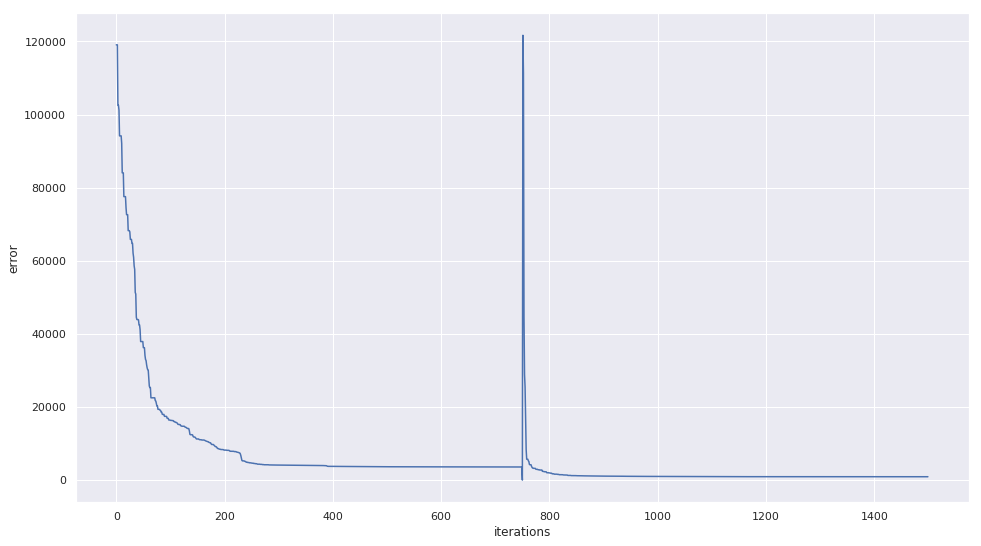

In [23]:
iterations = [i for i in range(1500)]
df3 = pd.DataFrame({'iterations': iterations, 'error': pgso_true_list})

plt.figure(figsize=(16,9))
sns.set()
_ = sns.lineplot(x="iterations",y="error", data=df3)

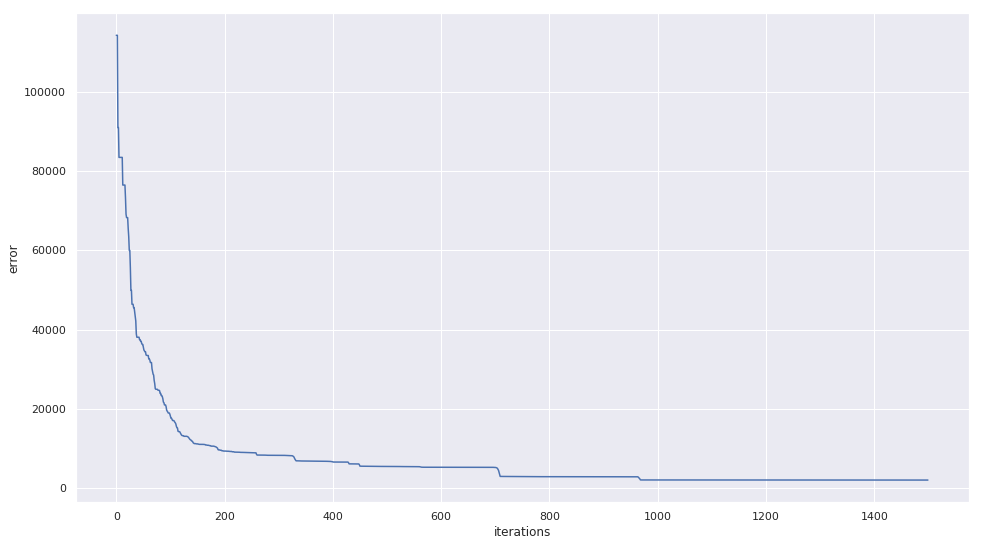

In [44]:
iterations = [i for i in range(1500)]
df3 = pd.DataFrame({'iterations': iterations, 'error': pgso_true_list})

plt.figure(figsize=(16,9))
sns.set()
_ = sns.lineplot(x="iterations",y="error", data=df3)

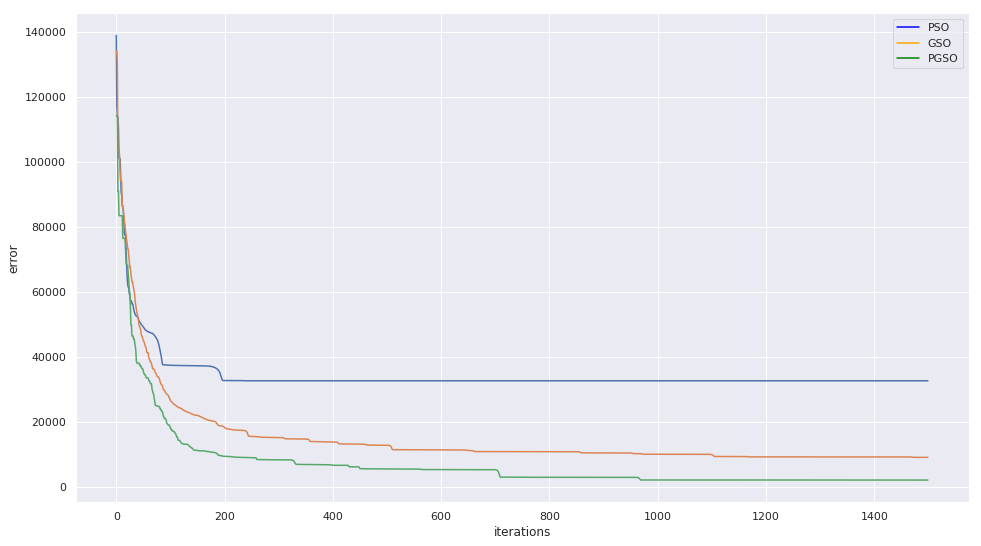

In [52]:
sns.set()
plt.figure(figsize=(16,9))
ax = plt.gca()
blue_line = mlines.Line2D([],[],color='blue', label='PSO', markersize='20')
orange_line = mlines.Line2D([],[],color='orange', label='GSO', markersize='20')
green_line = mlines.Line2D([],[],color='green', label='PGSO', markersize='20')

a = sns.lineplot(x='iterations', y='error', data=df, ax=ax)
b = sns.lineplot(x='iterations', y='error', data=df2, ax=ax)
c = sns.lineplot(x='iterations', y='error', data=df3, ax=ax)
# a.legend()
_ = ax.legend(handles=[blue_line, orange_line, green_line])

In [25]:
df3.columns

Index(['iterations', 'error'], dtype='object')

In [24]:
df3[df3.iterations == 750]

,iterations,error
750,750,-1.0


In [32]:
df3[df3.iterations == 750]

,iterations,error
750,750,-1.0


In [31]:
df3[(df3.error > 20000) & (df3.iterations > 400)]

,iterations,error
751,751,121670.318110
752,752,111259.861182
753,753,44724.769204
754,754,28864.445252
755,755,25451.687834


In [ ]:
def make_graph(algo, cost_func, bounds, max_iter, num_particles):
    # Run PSO First
    pso_list = list()
    search_space = [graph_bounds for _ in range(50)]
    True_PSO(cost_func, search_space, max_iter, num_particles, log=True, the_list=pso_list)
    
    # Run GSO
    gso_list = list()
    _ = GSO(M, search_space, num_particles, max_iter, cost_func, log=True, the_list=gso_list)
    gso_true_list = list()
    for i, j, k, l, m in zip(gso_list[0], gso_list[1], gso_list[2], gso_list[3], gso_list[4]):
        gso_true_list.append((i + j + k + l + m)/5)
    
    # RUN Pgso
    pgso_list = list()
    _ = PGSO(M, search_space, num_particles, max_iter, cost_func, log=True, the_list=pgso_list)
    pgso_true_list = list()
    for i, j, k, l, m in zip(pgso_list[0], pgso_list[1], pgso_list[2], pgso_list[3], pgso_list[4]):
        pgso_true_list.append((i + j + k + l + m)/5)